# Quantum Key Distribution

In [2]:
# boilerplate
import numpy as np
import pandas as pd
import matplotlib as plt
import os

# qiskit
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint
from qiskit.providers.aer import QasmSimulator

# other classes I wrote
import Alice
import Bob
import Eve
import Encrypt

Fact: measuring a quibit can change its state. If Eve attempts to access the information contained in the qubit sent from Alice to Bob, i.e. by measuring it, then it is possible that the state of the qubit will be changed.



## Demo 1: Without Interception

In [3]:
e = Encrypt.Encrypt(100)
e.run_without_intercept()

True

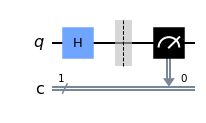

In [4]:
alice = Alice.Alice(100)
bob = Bob.Bob(100)
bits = alice.init_bitstring()
bases = alice.init_bases()
    
list = alice.encode_bitstring(bits, bases)
list[3].draw('mpl')

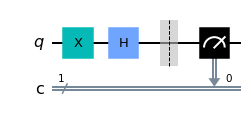

In [5]:
np.random.seed(seed=0)
n = 100

# Alice generates bits and bases
alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)

message = alice.encode_bitstring(alice_bits, alice_bases)
message[7].draw('mpl')

[0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]


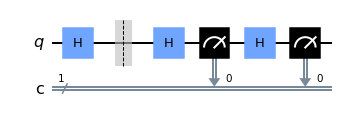

In [6]:
# now bob measures the message in a random sequence of bases of his choosing
bob_bases = randint(2, size=n)
bob_results = bob.measure_message(message, bob_bases) # this is the result for step 3.. bob keeps this result private
print(bob_results)
message[0].draw('mpl')

In [7]:
message[6].draw('mpl')
print(len(bob_results))

200


In [8]:
alice_key = alice.remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = bob.remove_garbage(alice_bases, bob_bases, bob_results)
print(f'Alice key = {alice_key}')
print(f'Bob key = {bob_key}')
print()

print(f'Len_alice = {len(alice_key)}')
print(f'Len_bob = {len(bob_key)}')
print()

print(alice_key == bob_key)

# now testing a random sample to make sure the protocol worked correctly
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = bob.share_random_sample(bob_key, bit_selection)
print("bob_sample = " + str(bob_sample))
alice_sample = alice.share_random_sample(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))


# if successful, true
print(bob_sample == alice_sample) 

Alice key = [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]
Bob key = [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]

Len_alice = 48
Len_bob = 48

True
bob_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
alice_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True


## Demo 2: With Interception

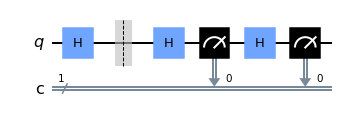

In [10]:
alice = Alice.Alice(100)
bob = Bob.Bob(100)
eve = Eve.Eve(100) # now, we need an eavesdropper


alice_bits = alice.init_bitstring()
alice_bases = alice.init_bases()
    
message = alice.encode_bitstring(alice_bits, alice_bases)
message[0].draw('mpl')

[1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1]


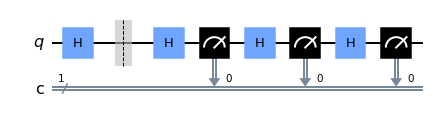

In [11]:
eve_bases = eve.init_bases()
intercept_message = eve.intercept_message(message, eve_bases)
print(intercept_message)
message[0].draw('mpl')

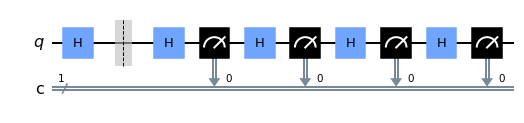

In [12]:
# Bob then checks like before and measures the message with his own choice of bases
bob_bases = bob.init_bases()
bob_results = bob.measure_message(message, bob_bases)
message[0].draw('mpl')

In [13]:
# just like before, Bob and Alice reveal choice of basis over Eve's public channel
bob_key = bob.remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = alice.remove_garbage(alice_bases, bob_bases, alice_bits)

In [14]:
sample_size = 15
bit_selection = randint(100, size=sample_size)
bob_sample = bob.share_random_sample(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = alice.share_random_sample(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1]
alice_sample = [0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]


In [15]:
# either due to noise or eavesdropping, the message in void
print(bob_sample == alice_sample)

False


## Example of Quantum Algorithm: BB84

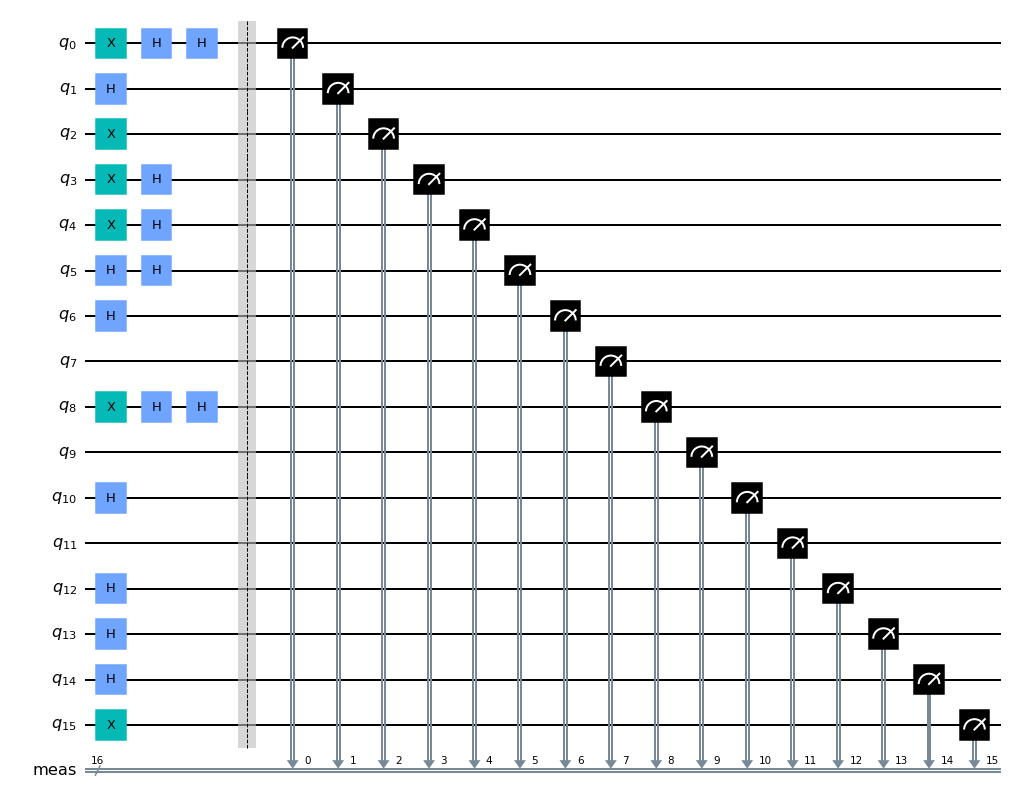

In [16]:
def bb84_circuit(state, basis, measurement_basis):
   
    #state: array of 0s and 1s denoting the state to be encoded
    #basis: array of 0s and 1s denoting the basis to be used for encoding
                #0 -> Computational Basis
                #1 -> Hadamard Basis
    #meas_basis: array of 0s and 1s denoting the basis to be used for measurement
                #0 -> Computational Basis
                #1 -> Hadamard Basis
    num_qubits = len(state)
    circuit = QuantumCircuit(num_qubits)

    # Sender prepares qubits
    for i in range(len(basis)):
        if state[i] == 1:
            circuit.x(i)
        if basis[i] == 1:
            circuit.h(i)
    # Measuring action performed by Bob
    for i in range(len(measurement_basis)):
        if measurement_basis[i] == 1:
            circuit.h(i)

       
    circuit.measure_all()
    
    return circuit

# 
num_qubits = 16

alice_basis = np.random.randint(2, size=num_qubits)
alice_state = np.random.randint(2, size=num_qubits)
bob_basis = np.random.randint(2, size=num_qubits)

bb84_circuit(alice_basis, alice_state, bob_basis).draw('mpl')